# Finetuning of ImageNet pretrained EfficientNet-B0 on CIFAR-100

Recently new ConvNets architectures have been proposed in ["EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks"](https://arxiv.org/pdf/1905.11946.pdf) paper. According to the paper, model's compound scaling starting from a 'good' baseline provides an network that achieves  state-of-the-art on  ImageNet,  while  being 8.4x  smaller and 6.1x faster on inference than the best existing ConvNet.

![efficientnets](assets/efficientnets.png)

Following the paper, EfficientNet-B0 model pretrained on ImageNet and finetuned on CIFAR100 dataset gives 88% test accuracy. Let's reproduce this result with Ignite. [Official implementation](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet) of EfficientNet uses Tensorflow, 
for our case we will borrow the code from [katsura-jp/efficientnet-pytorch](https://github.com/katsura-jp/efficientnet-pytorch), 
[rwightman/pytorch-image-models](https://github.com/rwightman/pytorch-image-models) and [lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/) repositories (kudos to authors!). We will download pretrained weights from [lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/) repository.

## Network architecture review
The architecture of EfficientNet-B0 is the following:
```
1 - Stem    - Conv3x3|BN|Swish

2 - Blocks  - MBConv1, k3x3 
            - MBConv6, k3x3 repeated 2 times
            - MBConv6, k5x5 repeated 2 times
            - MBConv6, k3x3 repeated 3 times
            - MBConv6, k5x5 repeated 3 times
            - MBConv6, k5x5 repeated 4 times
            - MBConv6, k3x3
                            totally 16 blocks

3 - Head    - Conv1x1|BN|Swish 
            - Pooling
            - Dropout
            - FC
```

where 
```
Swish(x) = x * sigmoid(x)
```
and `MBConvX` stands for mobile inverted bottleneck convolution, X - denotes expansion ratio:
``` 
MBConv1 : 
  -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6 : 
  -> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6+IdentitySkip : 
  -.-> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN-(+)->
   \___________________________________________________________________________/
```

## Installations

1) Torchvision

Please install torchvision in order to get CIFAR100 dataset: 
```
conda install -y torchvision -c pytorch
```

2) NVidia/apex

We will train with automatic mixed precision using [nvidia/apex](https://github.com/NVIDIA/apex) pacakge

```
git clone https://github.com/NVIDIA/apex && cd apex
pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
```

In [1]:
import random
import torch
import ignite

seed = 17
random.seed(seed)
_ = torch.manual_seed(seed)

In [2]:
torch.__version__, ignite.__version__

('1.1.0', '0.2.0')

## Model


Let's define some helpful modules:
- Flatten 
- Swish 

The reason why Swish is not implemented in `torch.nn` can be found [here](https://github.com/pytorch/pytorch/pull/3182).


In [3]:
import torch
import torch.nn as nn


class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)


class Flatten(nn.Module):
    
    def forward(self, x):
        return x.reshape(x.shape[0], -1)


Let's visualize Swish transform vs ReLU:

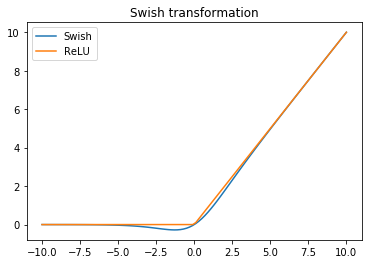

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

d = torch.linspace(-10.0, 10.0)
s = Swish()
res = s(d)
res2 = torch.relu(d)

plt.title("Swish transformation")
plt.plot(d.numpy(), res.numpy(), label='Swish')
plt.plot(d.numpy(), res2.numpy(), label='ReLU')
plt.legend()

Now let's define `SqueezeExcitation` module

In [5]:
class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x


Next, we can define `MBConv`.

**Note on implementation**: in Tensorflow (and PyTorch ports) convolutions use `SAME` padding option which in PyTorch requires
a specific padding computation and additional operation to apply. We will use built-in padding argument of the convolution.

In [6]:
from torch.nn import functional as F


class MBConv(nn.Module):

    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = torch.tensor(drop_connect_rate, requires_grad=False)
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                self._drop_connect(x)
            x += z
        return x

And finally, we can implement generic `EfficientNet`:

In [7]:
from collections import OrderedDict
import math


def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
    def _setup_repeats(self, num_repeats):
        return int(math.ceil(self.depth_coefficient * num_repeats))
    
    def _setup_channels(self, num_channels):
        num_channels *= self.width_coefficient
        new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
        new_num_channels = max(self.divisor, new_num_channels)
        if new_num_channels < 0.9 * num_channels:
            new_num_channels += self.divisor
        return new_num_channels

    def __init__(self, num_classes=100, 
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 se_rate=0.25,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.divisor = 8
                
        list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        list_channels = [self._setup_channels(c) for c in list_channels]
                
        list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
        list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
        
        expand_rates = [1, 6, 6, 6, 6, 6, 6]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

        # Define stem:
        self.stem = nn.Sequential(
            nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
            Swish()
        )
        
        # Define MBConv blocks
        blocks = []
        counter = 0
        num_blocks = sum(list_num_repeats)
        for idx in range(7):
            
            num_channels = list_channels[idx]
            next_num_channels = list_channels[idx + 1]
            num_repeats = list_num_repeats[idx]
            expand_rate = expand_rates[idx]
            kernel_size = kernel_sizes[idx]
            stride = strides[idx]
            drop_rate = drop_connect_rate * counter / num_blocks
            
            name = "MBConv{}_{}".format(expand_rate, counter)
            blocks.append((
                name,
                MBConv(num_channels, next_num_channels, 
                       kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                       se_rate=se_rate, drop_connect_rate=drop_rate)
            ))
            counter += 1
            for i in range(1, num_repeats):                
                name = "MBConv{}_{}".format(expand_rate, counter)
                drop_rate = drop_connect_rate * counter / num_blocks                
                blocks.append((
                    name,
                    MBConv(next_num_channels, next_num_channels, 
                           kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                           se_rate=se_rate, drop_connect_rate=drop_rate)                                    
                ))
                counter += 1
        
        self.blocks = nn.Sequential(OrderedDict(blocks))
        
        # Define head
        self.head = nn.Sequential(
            nn.Conv2d(list_channels[-2], list_channels[-1], 
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
            Swish(),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(list_channels[-1], num_classes)
        )

        self.apply(init_weights)
        
    def forward(self, x):
        f = self.stem(x)
        f = self.blocks(f)
        y = self.head(f)
        return y

All EfficientNet models can be defined using the following parametrization:
```
# (width_coefficient, depth_coefficient, resolution, dropout_rate)
'efficientnet-b0': (1.0, 1.0, 224, 0.2),
'efficientnet-b1': (1.0, 1.1, 240, 0.2),
'efficientnet-b2': (1.1, 1.2, 260, 0.3),
'efficientnet-b3': (1.2, 1.4, 300, 0.3),
'efficientnet-b4': (1.4, 1.8, 380, 0.4),
'efficientnet-b5': (1.6, 2.2, 456, 0.4),
'efficientnet-b6': (1.8, 2.6, 528, 0.5),
'efficientnet-b7': (2.0, 3.1, 600, 0.5),
```    
Let's define and train the third one: `EfficientNet-B0`

In [8]:
model = EfficientNet(num_classes=1000, 
                     width_coefficient=1.0, depth_coefficient=1.0, 
                     dropout_rate=0.2)

Number of parameters:

In [9]:
def print_num_params(model, display_all_modules=False):
    total_num_params = 0
    for n, p in model.named_parameters():
        num_params = 1
        for s in p.shape:
            num_params *= s
        if display_all_modules: print("{}: {}".format(n, num_params))
        total_num_params += num_params
    print("-" * 50)
    print("Total number of parameters: {:.2e}".format(total_num_params))
    

print_num_params(model)

--------------------------------------------------
Total number of parameters: 5.29e+06


Let's compare the number of parameters with some of ResNets:

In [10]:
from torchvision.models.resnet import resnet18, resnet34, resnet50

In [11]:
print_num_params(resnet18(pretrained=False, num_classes=100))
print_num_params(resnet34(pretrained=False, num_classes=100))
print_num_params(resnet50(pretrained=False, num_classes=100))

--------------------------------------------------
Total number of parameters: 1.12e+07
--------------------------------------------------
Total number of parameters: 2.13e+07
--------------------------------------------------
Total number of parameters: 2.37e+07


### Model's graph with Tensorboard

We can optionally inspect model's graph with the code below. For that we need to install
`tensorboardX` package.
Otherwise go directly to the next section.

In [12]:
from tensorboardX.pytorch_graph import graph

import random
from IPython.display import clear_output, Image, display, HTML


def show_graph(graph_def):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(random.randint(0, 1000)))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [13]:
x = torch.rand(4, 3, 224, 224)
graph_def = graph(model, x, operator_export_type='RAW')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


In [14]:
# Display in Firefox may not work properly. Use Chrome.
show_graph(graph_def[0])

### Load pretrained weights

Let's load pretrained weights and check the model on a single image.

In [15]:
# !mkdir /tmp/efficientnet_weights
# !wget http://storage.googleapis.com/public-models/efficientnet-b0-08094119.pth -O/tmp/efficientnet_weights/efficientnet-b0-08094119.pth

In [16]:
from collections import OrderedDict


model_state = torch.load("efficientnet-b0-08094119.pth")

# A basic remapping is required
mapping = {
    k: v for k, v in zip(model_state.keys(), model.state_dict().keys())
}
mapped_model_state = OrderedDict([
    (mapping[k], v) for k, v in model_state.items()
])

model.load_state_dict(mapped_model_state, strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
# !wget https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/img.jpg -O/tmp/giant_panda.jpg
# !wget https://raw.githubusercontent.com/lukemelas/EfficientNet-PyTorch/master/examples/simple/labels_map.txt -O/tmp/labels_map.txt

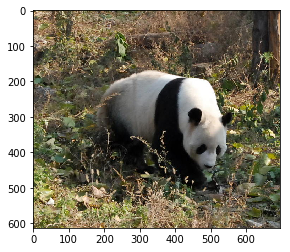

In [18]:
import json

with open("/tmp/labels_map.txt", "r") as h:
    labels = json.load(h)

from PIL import Image
import torchvision.transforms as transforms


img = Image.open("/tmp/giant_panda.jpg")
# Preprocess image
image_size = 224
tfms = transforms.Compose([transforms.Resize(image_size), 
                           transforms.CenterCrop(image_size), 
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
x = tfms(img).unsqueeze(0)

plt.imshow(img)

In [19]:
# Classify
model.eval()
with torch.no_grad():
    y_pred = model(x)

# Print predictions
print('-----')
for idx in torch.topk(y_pred, k=5).indices.squeeze(0).tolist():
    prob = torch.softmax(y_pred, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels[str(idx)], p=prob*100))

-----
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (92.71%)
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (0.28%)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.14%)
Staffordshire bullterrier, Staffordshire bull terrier                       (0.12%)
teddy, teddy bear                                                           (0.12%)


## Dataflow

Let's setup the dataflow:
- load CIFAR100 train and test datasets
- setup train/test image transforms
- setup train/test data loaders

According to the paper authors borrowed training settings from other publications and the dataflow for CIFAR100 is the following:

- input images to the network during training are resized to 224x224
- horizontally flipped randomly and augmented using cutout.
- each mini-batch contained 256 examples


In [20]:
from torchvision.datasets.cifar import CIFAR100 
from torchvision.transforms import Compose, RandomCrop, Pad, RandomHorizontalFlip, Resize
from torchvision.transforms import ToTensor, Normalize

from torch.utils.data import Subset

In [21]:
path = "/tmp/cifar100"

from PIL.Image import BICUBIC


train_transform = Compose([
    Resize(256, BICUBIC),
    RandomCrop(224),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Compose([
    Resize(224, BICUBIC),    
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = CIFAR100(root=path, train=True, transform=train_transform, download=True)
test_dataset = CIFAR100(root=path, train=False, transform=test_transform, download=False)

train_eval_indices = [random.randint(0, len(train_dataset) - 1) for i in range(len(test_dataset))]
train_eval_dataset = Subset(train_dataset, train_eval_indices)


len(train_dataset), len(test_dataset), len(train_eval_dataset)

Files already downloaded and verified


(50000, 10000, 10000)

In [22]:
from torch.utils.data import DataLoader


batch_size = 172

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=20, 
                          shuffle=True, drop_last=True, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=20, 
                         shuffle=False, drop_last=False, pin_memory=True)

eval_train_loader = DataLoader(train_eval_dataset, batch_size=batch_size, num_workers=20, 
                               shuffle=False, drop_last=False, pin_memory=True)

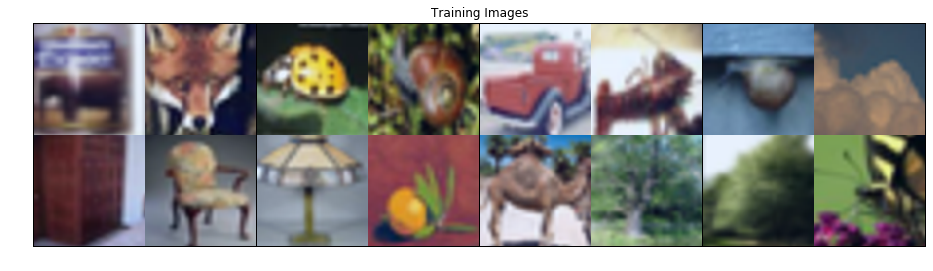

In [23]:
import torchvision.utils as vutils

# Plot some training images
batch = next(iter(train_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow( 
    vutils.make_grid(batch[0][:16], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)

batch = None
torch.cuda.empty_cache()

## Finetunning model

As we are interested to finetune the model to CIFAR-100, we will replace the classification fully-connected layer (ImageNet-1000 vs CIFAR-100).

In [24]:
model.head[6].in_features, model.head[6].out_features

(1280, 1000)

In [25]:
model.head[6] = nn.Linear(1280, 100)

In [26]:
model.head[6].in_features, model.head[6].out_features

(1280, 100)

We will finetune the model on GPU with AMP fp32/fp16 using nvidia/apex package.

In [27]:
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled, "NVIDIA/Apex:Amp requires cudnn backend to be enabled."
torch.backends.cudnn.benchmark = True

device = "cuda"

In [28]:
model = model.to(device)

Let's setup cross-entropy as criterion and SGD as optimizer.

We will split model parameters into 2 groups: 

    1) feature extractor (pretrained weights)
    2) classifier (random weights)

and define different learning rates for these groups (via learning rate scheduler).

In [29]:
from itertools import chain

import torch.optim as optim
import torch.nn.functional as F


criterion = nn.CrossEntropyLoss()

lr = 0.01

optimizer = optim.SGD([
    {
        "params": chain(model.stem.parameters(), model.blocks.parameters()),
        "lr": lr * 0.1,
    },
    {
        "params": model.head[:6].parameters(),
        "lr": lr * 0.2,
    },    
    {
        "params": model.head[6].parameters(), 
        "lr": lr
    }], 
    momentum=0.9, weight_decay=0.001, nesterov=True)


In [30]:
from torch.optim.lr_scheduler import ExponentialLR

lr_scheduler = ExponentialLR(optimizer, gamma=0.975)

In [31]:
try:
    from apex import amp
except ImportError:
    raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")


# Initialize Amp
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", num_losses=1)


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


Next, let's define a single iteration function `update_fn`. This function is then used by `ignite.engine.Engine` to update model while running over the input data.

In [32]:
from ignite.utils import convert_tensor


def update_fn(engine, batch):
    model.train()

    x = convert_tensor(batch[0], device=device, non_blocking=True)
    y = convert_tensor(batch[1], device=device, non_blocking=True)
    
    y_pred = model(x)
    
    # Compute loss 
    loss = criterion(y_pred, y)    

    optimizer.zero_grad()    
    with amp.scale_loss(loss, optimizer, loss_id=0) as scaled_loss:
        scaled_loss.backward()
    optimizer.step()
    
    return {
        "batchloss": loss.item(),
    }    

Let's check `update_fn`

In [33]:
batch = next(iter(train_loader))

res = update_fn(engine=None, batch=batch)

batch = None
torch.cuda.empty_cache()

res

{'batchloss': 4.627640247344971}

Now let's define a trainer and add some practical handlers:
- log to tensorboard: losses, metrics, lr
- progress bar
- models/optimizers checkpointing

In [34]:
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import RunningAverage, Accuracy, Precision, Recall, Loss, TopKCategoricalAccuracy

from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

In [35]:
trainer = Engine(update_fn)


def output_transform(out):
    return out['batchloss']


RunningAverage(output_transform=output_transform).attach(trainer, "batchloss")

In [36]:
from datetime import datetime

exp_name = datetime.now().strftime("%Y%m%d-%H%M%S")
log_path = "/tmp/finetune_efficientnet_cifar100/{}".format(exp_name)
tb_logger = TensorboardLogger(log_dir=log_path)


tb_logger.attach(trainer, 
                 log_handler=OutputHandler('training', ['batchloss', ]), 
                 event_name=Events.ITERATION_COMPLETED)

print("Experiment name: ", exp_name)

Experiment name:  20190608-201843


Let's setup learning rate scheduling:

In [37]:
trainer.add_event_handler(Events.EPOCH_COMPLETED, lambda engine: lr_scheduler.step())

# Log optimizer parameters
tb_logger.attach(trainer,
                 log_handler=OptimizerParamsHandler(optimizer, "lr"), 
                 event_name=Events.EPOCH_STARTED)

In [38]:
from ignite.contrib.handlers import ProgressBar

# Iteration-wise progress bar
# ProgressBar(bar_format="").attach(trainer, metric_names=['batchloss',])

# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer, 
                                                event_name=Events.EPOCH_STARTED, 
                                                closing_event_name=Events.COMPLETED)

/opt/conda/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Let's create two evaluators to compute metrics on train/test images and log them to Tensorboard:

In [39]:
metrics = {
    'Loss': Loss(criterion),
    'Accuracy': Accuracy(),
    'Precision': Precision(average=True),
    'Recall': Recall(average=True),
    'Top-5 Accuracy': TopKCategoricalAccuracy(k=5)
}


evaluator = create_supervised_evaluator(model, metrics=metrics, 
                                        device=device, non_blocking=True)

train_evaluator = create_supervised_evaluator(model, metrics=metrics, 
                                              device=device, non_blocking=True)

In [40]:
from ignite.contrib.handlers import CustomPeriodicEvent

cpe = CustomPeriodicEvent(n_epochs=3)
cpe.attach(trainer)


def run_evaluation(engine):
    train_evaluator.run(eval_train_loader)
    evaluator.run(test_loader)


trainer.add_event_handler(cpe.Events.EPOCHS_3_STARTED, run_evaluation)
trainer.add_event_handler(Events.COMPLETED, run_evaluation)


# Log train eval metrics:
tb_logger.attach(train_evaluator,
                 log_handler=OutputHandler(tag="training",
                                           metric_names=list(metrics.keys()),
                                           another_engine=trainer),
                 event_name=Events.EPOCH_COMPLETED)

# Log val metrics:
tb_logger.attach(evaluator,
                 log_handler=OutputHandler(tag="test",
                                           metric_names=list(metrics.keys()),
                                           another_engine=trainer),
                 event_name=Events.EPOCH_COMPLETED)

Now let's setup the best model checkpointing, early stopping:

In [ ]:
import logging

# Setup engine &  logger
def setup_logger(logger):
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s %(name)-12s %(levelname)-8s %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [ ]:
from ignite.handlers import ModelCheckpoint, global_step_from_engine, EarlyStopping, TerminateOnNan


trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())


# Store the best model
def default_score_fn(engine):
    score = engine.state.metrics['Accuracy']
    return score


best_model_handler = ModelCheckpoint(dirname=log_path,
                                     filename_prefix="best",
                                     n_saved=3,
                                     global_step_transform=global_step_from_engine(trainer),
                                     score_name="test_acc",
                                     score_function=default_score_fn)
evaluator.add_event_handler(Events.COMPLETED, best_model_handler, {'model': model, })

# Add early stopping
es_patience = 10
es_handler = EarlyStopping(patience=es_patience, score_function=default_score_fn, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, es_handler)
setup_logger(es_handler._logger)


# Clear cuda cache between training/testing
def empty_cuda_cache(engine):
    torch.cuda.empty_cache()
    import gc
    gc.collect()


trainer.add_event_handler(Events.EPOCH_COMPLETED, empty_cuda_cache)
evaluator.add_event_handler(Events.COMPLETED, empty_cuda_cache)
train_evaluator.add_event_handler(Events.COMPLETED, empty_cuda_cache)

In [ ]:
num_epochs = 100


trainer.run(train_loader, max_epochs=num_epochs)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


Finetunning results:

- Test dataset:

In [44]:
evaluator.state.metrics

{'Loss': 0.5794508318543434,
 'Accuracy': 0.8301,
 'Precision': 0.8343009381785126,
 'Recall': 0.8301,
 'Top-5 Accuracy': 0.9767}

- Training subset:

In [45]:
train_evaluator.state.metrics

{'Loss': 0.15383066653311253,
 'Accuracy': 0.9659,
 'Precision': 0.9665485177748749,
 'Recall': 0.9663592917117214,
 'Top-5 Accuracy': 0.9984}

Obviously, our training settings is not the optimal one and the delta between our result and the paper's one is about 5%.

## Inference

Let's load the best model and recompute evaluation metrics on test dataset with a very basic Test-Time-Augmentation to boost the performances.


In [52]:
# Setup the last experiment's folder: 
p = "/tmp/finetune_efficientnet_cifar100/20190608-201843"
!ls {p}

best_model_24_test_acc=0.8297.pth  best_model_35_test_acc=0.8301.pth
best_model_32_test_acc=0.83.pth    events.out.tfevents.1560025123.user-machine


In [95]:
best_model = EfficientNet()
best_model.load_state_dict(torch.load(p + "/best_model_35_test_acc=0.8301.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [101]:
metrics = {
    'Accuracy': Accuracy(),
    'Precision': Precision(average=True),
    'Recall': Recall(average=True),
}


def inference_update_with_tta(engine, batch):
    best_model.eval()
    with torch.no_grad():
        x, y = batch        
        # Let's compute final prediction as a mean of predictions on x and flipped x
        y_pred1 = best_model(x)
        y_pred2 = best_model(x.flip(dims=(-1, )))
        y_pred = 0.5 * (y_pred1 + y_pred2)

        return y_pred, y


inferencer = Engine(inference_update_with_tta)

In [102]:
for name, metric in metrics.items():
    metric.attach(inferencer, name)

In [103]:
ProgressBar(desc="Inference").attach(inferencer)

In [104]:
result_state = inferencer.run(test_loader, max_epochs=1)

Finally, we obtain similar scores:

In [107]:
result_state.metrics

{'Accuracy': 0.8347, 'Precision': 0.8391453337228768, 'Recall': 0.8347}